(image_zoom)=
# Zooming an image

We need to be able to select a small region of a landsat image to work with.  This notebook

1. zooms in on a 400 pixel wide x 600 pixel high subscene centered on  Vancouver,  using pyproj and the affine transform to map from lat,lon to x,y in UTM zone 10N to row, column in the landsat image

2. Puts on crude coastlines in the UTM-10N crs

3. Calculates the new affine transform for the subcene, and writes the image out to a 1 Mbyte tiff file

In [1]:
import copy
import pprint
from pathlib import Path

import cartopy
import numpy as np
import numpy.random
import rasterio
from affine import Affine
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from pyproj import CRS, Transformer

import a301_lib  # noqa
from sat_lib.landsat.toa_reflectance import toa_reflectance_8

******************************
context imported. Front of path:
/home/phil/work

in sat_lib init


* Get the tiff files and calculate band 5 reflectance

In [2]:
week10_dir = Path().resolve()
band4 = (week10_dir.parent / "week9/landsat_scenes").glob("**/*B4.TIF")
band4 = list(band4)[0]
band5 = (week10_dir.parent / "week9/landsat_scenes").glob("**/*B5.TIF")
band5 = list(band5)[0]
mtl_file = (week10_dir.parent / "week9/landsat_scenes").glob("**/*MTL.txt")
mtl_file = list(mtl_file)[0]

## Save the crs and the full_affine

We need to keep both full_affine (the affine transform for the full scene, and the coordinate reference system for pyproj (called crs below)

In [3]:
with rasterio.open(band5) as b5_raster:
    full_affine = b5_raster.transform
    crs = b5_raster.crs
    full_profile = b5_raster.profile
    refl = toa_reflectance_8([5], mtl_file)
    b5_refl = refl[5]

Scene LC80470262015165LGN02 center time is 2015-06-14 19:00:43


Text(0.5, 1.0, 'band 5 reflectance whole scene')

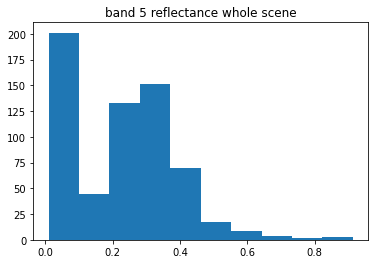

In [4]:
subset = np.random.randint(0, high=len(b5_refl.flat), size=1000, dtype="l")
plt.hist(b5_refl.flat[subset])
plt.title("band 5 reflectance whole scene")

In [5]:
print(f"profile: \n{pprint.pformat(full_profile)}")

profile: 
{'blockxsize': 512,
 'blockysize': 512,
 'compress': 'deflate',
 'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'uint16',
 'height': 7961,
 'interleave': 'band',
 'nodata': None,
 'tiled': True,
 'transform': Affine(30.0, 0.0, 397185.0,
       0.0, -30.0, 5531415.0),
 'width': 7851}


## Locate UBC on the map

We need to project the center of campus from lon/lat to UTM 10N x,y using pyproj.Transformer and our crs (which in this case is UTM).  We can transform from lon,lat (p_lonlat) to x,y (p_utm) to anchor us to a known point in the map coordinates.

In [6]:
p_utm = crs
p_latlon = CRS.from_proj4("+proj=latlon")
transform = Transformer.from_crs(p_latlon, p_utm)
ubc_lon = -123.2460
ubc_lat = 49.2606
ubc_x, ubc_y = transform.transform(ubc_lon, ubc_lat)

## Locate UBC on the image

Now we need to use the affine transform to go between x,y and
col, row on the image.  The next cell creates two slice objects that extend  on either side of the center point.  The tilde (~) in front of the transform indicates that we're going from x,y to col,row, instead of col,row to x,y.  (See [this blog entry](http://www.perrygeo.com/python-affine-transforms.html) for reference.)  Remember that row 0 is the top row, with rows decreasing downward to the south.  To demonstrate, the cell below uses the tranform to calculate the x,y coordinates of the (0,0) corner.

In [7]:
full_ul_xy = np.array(full_affine * (0, 0))
print(f"orig ul corner x,y (km)={full_ul_xy*1.e-3}")

orig ul corner x,y (km)=[ 397.185 5531.415]


## make our subscene 400 pixels wide and 600 pixels tall, using UBC as a reference point

We need to find the right rows and columns on the image to save for the subscene.  Do this by working outward from UBC by a certain number of pixels in each direction, using the inverse of the full_affine transform to go from x,y to col,row

In [8]:
ubc_col, ubc_row = ~full_affine * (ubc_x, ubc_y)
ubc_col, ubc_row = int(ubc_col), int(ubc_row)
l_col_offset = -100
r_col_offset = +300
b_row_offset = +100
t_row_offset = -500
col_slice = slice(ubc_col + l_col_offset, ubc_col + r_col_offset)
row_slice = slice(ubc_row + t_row_offset, ubc_row + b_row_offset)
section = b5_refl[row_slice, col_slice]
ubc_ul_xy = full_affine * (col_slice.start, row_slice.start)
ubc_lr_xy = full_affine * (col_slice.stop, row_slice.stop)
ubc_ul_xy, ubc_lr_xy

((479085.0, 5471475.0), (491085.0, 5453475.0))

In [9]:
upper_left_col = ubc_col + l_col_offset
upper_left_row = ubc_row + t_row_offset
print(upper_left_row, upper_left_col)

1998 2730


# Plot the raw band 5 image, clipped to reflectivities below 0.6

This is a simple check that we got the right section.

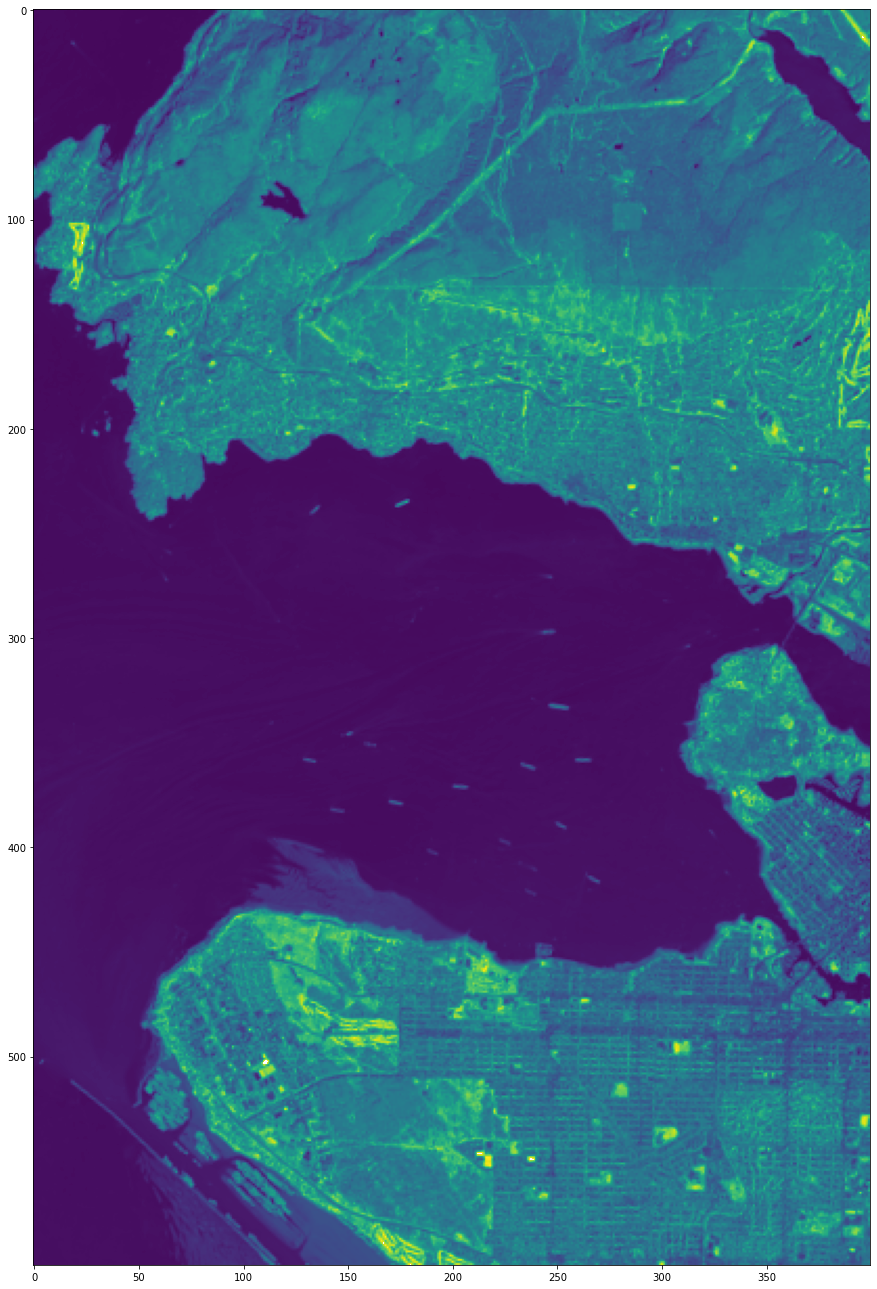

In [10]:
vmin = 0.0
vmax = 0.6
the_norm = Normalize(vmin=vmin, vmax=vmax, clip=False)
palette = "viridis"
pal = copy.copy(plt.get_cmap(palette))
pal.set_bad("0.75")  # 75% grey for out-of-map cells
pal.set_over("w")  # color cells > vmax red
pal.set_under("k")  # color cells < vmin black
fig, ax = plt.subplots(1, 1, figsize=(15, 25))
ax.imshow(section, cmap=pal, norm=the_norm, origin="upper")

## put this on a map

Note that the origin is switched to "lower" in the x,y coordinate system below,
since y increases upwards.  The coastline is very crude, but at least indicates we've got the coords roughly correct.  See the "high_res_map" notebook for a better coastline.

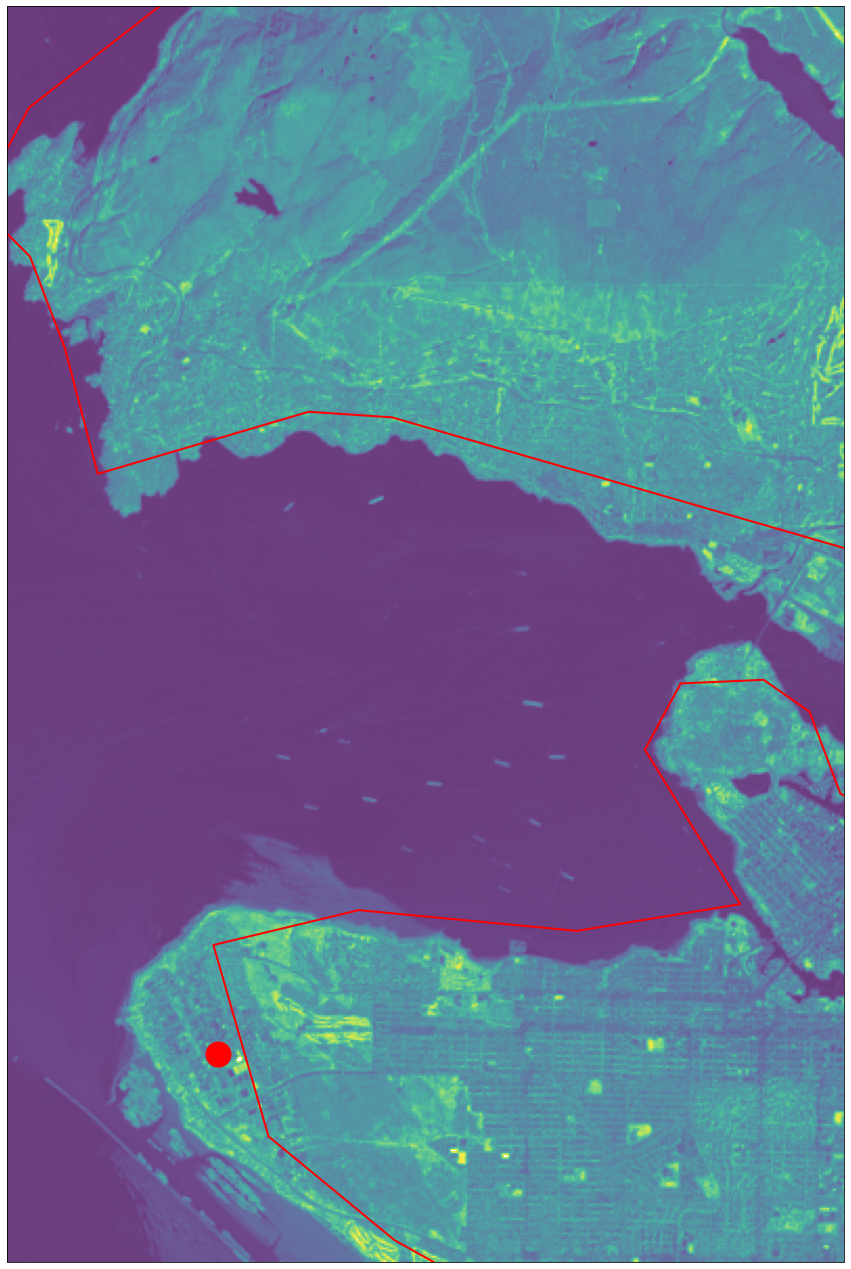

In [11]:
cartopy_crs = cartopy.crs.epsg(crs.to_epsg())
fig, ax = plt.subplots(1, 1, figsize=[15, 25], subplot_kw={"projection": cartopy_crs})
image_extent = [ubc_ul_xy[0], ubc_lr_xy[0], ubc_lr_xy[1], ubc_ul_xy[1]]
ax.imshow(
    section,
    cmap=pal,
    norm=the_norm,
    origin="upper",
    extent=image_extent,
    transform=cartopy_crs,
    alpha=0.8,
)
ax.coastlines(resolution="10m", color="red", lw=2)
ax.plot(ubc_x, ubc_y, "ro", markersize=25)
ax.set_extent(image_extent, crs=cartopy_crs)

##  Use  rasterio  to write a new tiff file

* Set the affine transform for the scene

We can write this clipped image back out to a much smaller tiff file if we can come up with the new affine transform for the smaller scene.  Referring again [to the writeup](http://www.perrygeo.com/python-affine-transforms.html) we need:

    a = width of a pixel
    b = row rotation (typically zero)
    c = x-coordinate of the upper-left corner of the upper-left pixel
    d = column rotation (typically zero)
    e = height of a pixel (typically negative)
    f = y-coordinate of the of the upper-left corner of the upper-left pixel

which will gives:

new_affine=Affine(a,b,c,d,e,f)

In addition, need to add a third dimension to the section array, because
rasterio expects [band,x,y] for its writer.  Do this with np.newaxis in the next cell

In [12]:
image_height, image_width = section.shape
ul_x, ul_y = ubc_ul_xy[0], ubc_ul_xy[1]
new_affine = Affine(30.0, 0.0, ul_x, 0.0, -30.0, ul_y)
out_section = section[np.newaxis, ...]
print(out_section.shape)

(1, 600, 400)


*  Now write this out to small_file.tiff

See the hires_map notebook for how to read this in and plot it

In [13]:
tif_filename = week10_dir / Path("small_file.tiff")
num_chans = 1
with rasterio.open(
    tif_filename,
    "w",
    driver="GTiff",
    height=image_height,
    width=image_width,
    count=num_chans,
    dtype=out_section.dtype,
    crs=crs,
    transform=new_affine,
    nodata=0.0,
) as dst:
    dst.write(out_section)
    section_profile = dst.profile

print(f"section profile: {pprint.pformat(section_profile)}")

section profile: {'count': 1,
 'crs': CRS.from_epsg(32610),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 600,
 'interleave': 'band',
 'nodata': 0.0,
 'tiled': False,
 'transform': Affine(30.0, 0.0, 479085.0,
       0.0, -30.0, 5471475.0),
 'width': 400}
